In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import psycopg2

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
table_cols = [('age_group', 'reporting_phu_city', 'cause_of_infection', 'gender', 'Resolved', 'Fatal', 'Special_Measure_Key')]
fact_table = []

def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        return psycopg2.connect(
            host="www.eecs.uottawa.ca",
            database="group_21",
            user="****",
            password="****",
            port="15432"
        )
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)


connection = connect()
print('***Connection established***')

cur = connection.cursor()
        
cur.execute('SELECT I.age_group, I.reporting_phu_city,\
            I.cause_of_infection, I.gender, F."Resolved",\
            F."Fatal", F."Special_Measure_Key" FROM fact_table_v2 as F\
            INNER JOIN individuals as I on I.individual_id = F."Individual_Key"')
rows = cur.fetchall()
fact_table = rows
print(fact_table[:10])

cur.close()
connection.close()
print('***Connection terminated***')

Connecting to the PostgreSQL database...
***Connection established***
[('40s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('30s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('90+', 'Toronto', 'OB', 'FEMALE', 'no', 'yes', 11), ('80s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('50s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('30s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('50s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('50s', 'Toronto', 'OB', 'MALE', 'yes', 'no', 11), ('20s', 'Toronto', 'OB', 'FEMALE', 'yes', 'no', 11), ('80s', 'Toronto', 'NO KNOWN EPI LINK', 'FEMALE', 'yes', 'no', 2)]
***Connection terminated***


In [3]:
result_df = pd.DataFrame(fact_table, columns=["age_group", "reporting_phu_city", "cause_of_infection", 
                                               "gender", "Resolved","Fatal","Special_Measure_Key"])
result_df.head()

,age_group,reporting_phu_city,cause_of_infection,gender,Resolved,Fatal,Special_Measure_Key
0,40s,Toronto,OB,FEMALE,yes,no,11
1,30s,Toronto,OB,FEMALE,yes,no,11
2,90+,Toronto,OB,FEMALE,no,yes,11
3,80s,Toronto,OB,FEMALE,yes,no,11
4,50s,Toronto,OB,FEMALE,yes,no,11


### One Hot Encoding
##### Class = Age Group
- create 9 columns with boolean values and check for imbalance
- one hot encoding to turn into 0s and 1s and then more preprocessing to convert those to boolean values

##### Features
- City, Cause of Infection, Gender, Resolved, Fatal, Special Measures

In [5]:
new_result_df = pd.get_dummies(result_df, prefix=["age_group", "reporting_phu_city", "cause_of_infection", "gender", "Resolved", "Fatal"])
X = new_result_df.values
new_result_df.head()

,Special_Measure_Key,age_group_20s,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,age_group_80s,age_group_90+,age_group_<20,age_group_UNKNOWN,reporting_phu_city_Ottawa,reporting_phu_city_Toronto,cause_of_infection_CC,cause_of_infection_MISSING INFORMATION,cause_of_infection_NO KNOWN EPI LINK,cause_of_infection_OB,cause_of_infection_TRAVEL,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,Resolved_no,Resolved_yes,Fatal_no,Fatal_yes
0,11,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0
1,11,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0
2,11,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
3,11,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0
4,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0


Special Measures is a bit more complicated so need to do some more processing. Using the sklearn library to handle the complications.

In [13]:
# Create Labeler and Encoder
labelencoder = LabelEncoder()
encoder = OneHotEncoder(dtype=int, handle_unknown='ignore')

In [9]:
# Assigning numerical values and storing in another column
new_result_df['Special_Measure_Key_Tmp'] = labelencoder.fit_transform(new_result_df['Special_Measure_Key'])
new_result_df.head()

,Special_Measure_Key,age_group_20s,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,age_group_80s,age_group_90+,age_group_<20,age_group_UNKNOWN,reporting_phu_city_Ottawa,reporting_phu_city_Toronto,cause_of_infection_CC,cause_of_infection_MISSING INFORMATION,cause_of_infection_NO KNOWN EPI LINK,cause_of_infection_OB,cause_of_infection_TRAVEL,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,Resolved_no,Resolved_yes,Fatal_no,Fatal_yes,Special_Measure_Key_Tmp
0,11,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,6
1,11,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,6
2,11,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,6
3,11,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,6
4,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,6


In [14]:
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(encoder.fit_transform(new_result_df[['Special_Measure_Key_Tmp']]).toarray())

In [15]:
#  merge with main df bridge_df on key values
new_result_df = new_result_df.join(enc_df)
new_result_df.rename(columns={6: "lockdown", 10: "stage 3 extended to toronto", 2: "Restart", 1: "Gatineau-Ottawa Travel Restriction", 3: "Parks Re-opened"},inplace = True)
new_result_df = new_result_df.drop(['Special_Measure_Key_Tmp'], axis=1)
new_result_df.head()

,Special_Measure_Key,age_group_20s,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,age_group_80s,age_group_90+,age_group_<20,age_group_UNKNOWN,reporting_phu_city_Ottawa,reporting_phu_city_Toronto,cause_of_infection_CC,cause_of_infection_MISSING INFORMATION,cause_of_infection_NO KNOWN EPI LINK,cause_of_infection_OB,cause_of_infection_TRAVEL,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,Resolved_no,Resolved_yes,Fatal_no,Fatal_yes,0,Gatineau-Ottawa Travel Restriction,Restart,Parks Re-opened,4,5,lockdown
0,11,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1
1,11,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1
2,11,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1
3,11,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1
4,11,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1


In [16]:
new_result_df = new_result_df.drop(['Special_Measure_Key', 4, 5], axis=1)
new_result_df.head()

,age_group_20s,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,age_group_80s,age_group_90+,age_group_<20,age_group_UNKNOWN,reporting_phu_city_Ottawa,reporting_phu_city_Toronto,cause_of_infection_CC,cause_of_infection_MISSING INFORMATION,cause_of_infection_NO KNOWN EPI LINK,cause_of_infection_OB,cause_of_infection_TRAVEL,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,Resolved_no,Resolved_yes,Fatal_no,Fatal_yes,0,Gatineau-Ottawa Travel Restriction,Restart,Parks Re-opened,lockdown
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1


In [20]:
new_result_df['age_group_20s'] = new_result_df['age_group_20s'].astype(bool)
new_result_df['age_group_30s'] = new_result_df['age_group_30s'].astype(bool)
new_result_df['age_group_40s'] = new_result_df['age_group_40s'].astype(bool)
new_result_df['age_group_50s'] = new_result_df['age_group_50s'].astype(bool)
new_result_df['age_group_60s'] = new_result_df['age_group_60s'].astype(bool)
new_result_df['age_group_70s'] = new_result_df['age_group_70s'].astype(bool)
new_result_df['age_group_80s'] = new_result_df['age_group_80s'].astype(bool)
new_result_df['age_group_90+'] = new_result_df['age_group_90+'].astype(bool)
new_result_df['age_group_<20'] = new_result_df['age_group_<20'].astype(bool)
new_result_df['age_group_UNKNOWN'] = new_result_df['age_group_UNKNOWN'].astype(bool)
new_result_df.head()

,age_group_20s,age_group_30s,age_group_40s,age_group_50s,age_group_60s,age_group_70s,age_group_80s,age_group_90+,age_group_<20,age_group_UNKNOWN,reporting_phu_city_Ottawa,reporting_phu_city_Toronto,cause_of_infection_CC,cause_of_infection_MISSING INFORMATION,cause_of_infection_NO KNOWN EPI LINK,cause_of_infection_OB,cause_of_infection_TRAVEL,gender_FEMALE,gender_GENDER DIVERSE,gender_MALE,gender_UNSPECIFIED,Resolved_no,Resolved_yes,Fatal_no,Fatal_yes,0,Gatineau-Ottawa Travel Restriction,Restart,Parks Re-opened,lockdown
0,False,False,True,False,False,False,False,False,False,False,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1
1,False,True,False,False,False,False,False,False,False,False,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1
2,False,False,False,False,False,False,False,True,False,False,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1
3,False,False,False,False,False,False,True,False,False,False,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1
4,False,False,False,True,False,False,False,False,False,False,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1


### Undersampling

In [24]:
from collections import Counter 
Counter(new_result_df['age_group_20s'])

Counter({False: 13125, True: 2131})

In [25]:
Counter(new_result_df['age_group_30s'])

Counter({False: 13219, True: 2037})

In [26]:
Counter(new_result_df['age_group_40s'])

Counter({False: 13149, True: 2107})

In [27]:
Counter(new_result_df['age_group_50s'])

Counter({False: 12859, True: 2397})

In [28]:
Counter(new_result_df['age_group_60s'])

Counter({False: 13612, True: 1644})

In [29]:
Counter(new_result_df['age_group_70s'])

Counter({False: 14135, True: 1121})

In [30]:
Counter(new_result_df['age_group_80s'])

Counter({False: 13569, True: 1687})

In [31]:
Counter(new_result_df['age_group_90+'])

Counter({False: 13973, True: 1283})

In [32]:
Counter(new_result_df['age_group_<20'])

Counter({False: 14408, True: 848})

All classes are highly imbalanced. It's even more clear by plotting 'age group 20s'.

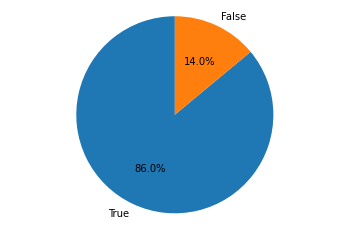

In [36]:
import matplotlib.pyplot as plt

labels = 'True', 'False'
sizes = [13125, 2131]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.show()

Therefore, it is likely if we train our model to classify 'age group 20s' on this dataset, during testing it will more often than not predict false.

In [53]:
from sklearn.utils import resample

df_majority = new_result_df[new_result_df.age_group_20s==False]
df_minority = new_result_df[new_result_df.age_group_20s==True]

df_majority_upsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=2131,    # to match minority class
                                 random_state=42)

df_upsampled = pd.concat([df_minority, df_majority_upsampled])

df_upsampled.age_group_20s.value_counts()

True     2131
False    2131
Name: age_group_20s, dtype: int64